# Yelp data

You can use the tool below to pull in search results from Yelp for businesses and other establishments in a given neighborhood. The tool is currently set up to pull in all search results for Red Hook regardless of the establishment type. The API call will return lists containing dictionaries with each dictionary corresponding to one specific establishment.

Note that in order to run the code, you will need to enter your own API key. You can also refine the searches by adding specific search terms (like "bar" or "restaurant"), price, and other search tools available on Yelp.

## Libraries

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pylab as plt
import urllib.request
import copy
import geopandas as gpd
import shapely
from shapely.geometry import Point
from fiona.crs import from_epsg

try:
    # For Python 3.0 and later
    from urllib.error import HTTPError
    from urllib.parse import quote
    from urllib.parse import urlencode
except ImportError:
    # Fall back to Python 2's urllib2 and urllib
    from urllib2 import HTTPError
    from urllib import quote
    from urllib import urlencode

In [2]:
# Save your API key in a text file with the key in the first line and no other text
API_KEY = open('api/yelp_api.txt', 'r').readlines()[0][:].rstrip()

## Functions for API calls

In [3]:
# You no longer need to provide Client ID to fetch Data
# It now uses private keys to authenticate requests (API Key)
# You can find it on
# https://www.yelp.com/developers/v3/manage_app

# API constants, you shouldn't have to change these.
API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/businesses/search'
BUSINESS_PATH = '/v3/businesses/'  # Business ID will come after slash.
REVIEW_PATH = '/v3/businesses/{}/reviews'

# Set search limit due to API restrictions
SEARCH_LIMIT = 50

def request(host, path, api_key, url_params=None):
    """Given your API_KEY, send a GET request to the API.
    Args:
        host (str): The domain host of the API.
        path (str): The path of the API after the domain.
        API_KEY (str): Your API Key.
        url_params (dict): An optional set of query parameters in the request.
    Returns:
        dict: The JSON response from the request.
    Raises:
        HTTPError: An error occurs from the HTTP request.
    """
    url_params = url_params or {}
    url = '{0}{1}'.format(host, quote(path.encode('utf8')))
    headers = {
        'Authorization': 'Bearer %s' % api_key,
    }

    response = requests.request('GET', url, headers=headers, params=url_params)

    return response.json()

def radius_search(api_key, latitude, longitude, radius, offset):
    """Query the Search API
    Returns:
        dict: The JSON response from the request.
    """

    url_params = {
        'latitude': latitude,
        'longitude': longitude,
        'radius': radius,
        'limit': SEARCH_LIMIT,
        'offset': offset
    }
    return request(API_HOST, SEARCH_PATH, api_key, url_params=url_params)

def query_api(latitude, longitude, radius, offset):
    # Queries the API by the input values from the user.
    response = radius_search(API_KEY, latitude, longitude, radius, offset)

    businesses = response.get('businesses')
    return businesses

def get_review(api_key, biz_id):
    return request(API_HOST, REVIEW_PATH.format(biz_id), api_key)

# # Still working on this part, not sure how to get it to work right (but the previous function works)
# def get_reviews(api_key, biz_ids):
#     responses = []
#     for biz_id in biz_ids:
#         response = request(API_HOST, REVIEW_PATH.format(biz_id), api_key)
#         responses.append(response)
#     return responses

## Getting establishments near project site

In [4]:
# Create offsets for multiple API calls since Yelp limits the number of requests one can make at a time
offsets = [0]
# Control the total number of results using the second argument in the below range (50 * __)
for i in range(1,10):
    off = i*50
    offsets.append(off)

In [5]:
"""
Set search radius (in meters) - max allowable value is 40,000.

800 meter radius around Red Hook centroid roughly covers all of Red Hook.
"""
radius = 800

In [6]:
"""
Loop through multiple queries to get the first 500 results for Red Hook.

Note that the API call results in 500 dictionaries - each dictionary contains the information for one business.
"""
results = []
for i in range(len(offsets)):
    # Using centroid for Red Hook CTs 53, 59, and 85
    businesses = query_api(40.67554871068841, -74.0091782600863, radius, offsets[i])
    results.append(businesses)

In [7]:
# To see how many total results were received from query
for i in range(len(results)):
    print("Batch {}: {} results".format(i,len(results[i])))

Batch 0: 50 results
Batch 1: 10 results
Batch 2: 0 results
Batch 3: 0 results
Batch 4: 0 results
Batch 5: 0 results
Batch 6: 0 results
Batch 7: 0 results
Batch 8: 0 results
Batch 9: 0 results


In [8]:
# Sample of result from API call
results[0][0]

{'id': 'Ms3CAGddVbgetiQrpzqxPQ',
 'alias': 'hometown-bar-b-que-brooklyn-3',
 'name': 'Hometown Bar-B-Que',
 'image_url': 'https://s3-media2.fl.yelpcdn.com/bphoto/Eo9NJvaF8j9HLa0GX9yNUA/o.jpg',
 'is_closed': False,
 'url': 'https://www.yelp.com/biz/hometown-bar-b-que-brooklyn-3?adjust_creative=blQ-cNUMXpZs8T2qda_yow&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=blQ-cNUMXpZs8T2qda_yow',
 'review_count': 1212,
 'categories': [{'alias': 'bbq', 'title': 'Barbeque'},
  {'alias': 'smokehouse', 'title': 'Smokehouse'}],
 'rating': 4.0,
 'coordinates': {'latitude': 40.6748965703426, 'longitude': -74.0160489746129},
 'transactions': [],
 'price': '$$',
 'location': {'address1': '454 Van Brunt St',
  'address2': '',
  'address3': None,
  'city': 'Brooklyn',
  'zip_code': '11231',
  'country': 'US',
  'state': 'NY',
  'display_address': ['454 Van Brunt St', 'Brooklyn, NY 11231']},
 'phone': '+13472944644',
 'display_phone': '(347) 294-4644',
 'distance': 583.9407138632308}

In [9]:
# Make a df from the results
dfs_list = []
for i in range(len(results)):
    temp_df = pd.DataFrame(results[i])
    dfs_list.append(temp_df)
biz_df = pd.concat(dfs_list)
biz_df.reset_index(inplace=True)
biz_df.head()

,index,alias,categories,coordinates,display_phone,distance,id,image_url,is_closed,location,name,phone,price,rating,review_count,transactions,url
0,0,hometown-bar-b-que-brooklyn-3,"[{'alias': 'bbq', 'title': 'Barbeque'}, {'alia...","{'latitude': 40.6748965703426, 'longitude': -7...",(347) 294-4644,583.940714,Ms3CAGddVbgetiQrpzqxPQ,https://s3-media2.fl.yelpcdn.com/bphoto/Eo9NJv...,False,"{'address1': '454 Van Brunt St', 'address2': '...",Hometown Bar-B-Que,+13472944644,$$,4.0,1212,[],https://www.yelp.com/biz/hometown-bar-b-que-br...
1,1,red-hook-lobster-pound-brooklyn,"[{'alias': 'seafood', 'title': 'Seafood'}]","{'latitude': 40.6797687107191, 'longitude': -7...",(718) 858-7650,479.860312,nOjGNqPcu5jHRRElOndQqQ,https://s3-media3.fl.yelpcdn.com/bphoto/saTV5k...,False,"{'address1': '284 Van Brunt St', 'address2': '...",Red Hook Lobster Pound,+17188587650,$$,4.0,946,"[delivery, pickup]",https://www.yelp.com/biz/red-hook-lobster-poun...
2,2,baked-brooklyn,"[{'alias': 'bakeries', 'title': 'Bakeries'}, {...","{'latitude': 40.676789, 'longitude': -74.013211}",(718) 222-0345,366.984075,Q_7J5E-cYCQfHNCkCyMdLA,https://s3-media1.fl.yelpcdn.com/bphoto/vpA4Pd...,False,"{'address1': '359 Van Brunt St', 'address2': '...",Baked,+17182220345,$$,4.0,496,[],https://www.yelp.com/biz/baked-brooklyn?adjust...
3,3,defontes-brooklyn,"[{'alias': 'sandwiches', 'title': 'Sandwiches'}]","{'latitude': 40.6789444357833, 'longitude': -7...",(718) 625-8052,495.737279,d_rQ-nVpY6Z5C722Q5wpog,https://s3-media3.fl.yelpcdn.com/bphoto/5ugsEH...,False,"{'address1': '379 Columbia St', 'address2': ''...",Defontes,+17186258052,$$,4.5,314,[],https://www.yelp.com/biz/defontes-brooklyn?adj...
4,4,the-good-fork-brooklyn,"[{'alias': 'newamerican', 'title': 'American (...","{'latitude': 40.67599, 'longitude': -74.01432}",(718) 643-6636,434.344880,-BOAKHyKKAXE1WhuVpMFkQ,https://s3-media2.fl.yelpcdn.com/bphoto/JFWO8Z...,False,"{'address1': '391 Van Brunt St', 'address2': '...",The Good Fork,+17186436636,$$,4.0,400,[],https://www.yelp.com/biz/the-good-fork-brookly...


In [10]:
print("Number of establishments listed on Yelp within {} meters of site centroid: {}".format(radius, \
                                                                                             biz_df.shape[0]))

Number of establishments listed on Yelp within 800 meters of site centroid: 60


In [11]:
# Load RH geo data
rh_comb_tract = gpd.read_file('data/created_data/rh_comb_tract/rh_comb_tract.shp')
rh_comb_center = gpd.read_file('data/created_data/rh_centroid/rh_centroid.shp')
rh_buffer = gpd.read_file('data/created_data/rh_centroid_buffer/rh_centroid_buffer.shp')
site_poly = gpd.read_file('data/created_data/site/site_poly/site_poly.shp')
site_centroid = gpd.read_file('data/created_data/site/site_centroid/site_centroid.shp')
site_buffer = gpd.read_file('data/created_data/site/site_centroid_buffer/site_centroid_buffer.shp')

In [12]:
# Reformat coordinates for shapely transformation and join to keep only businesses in RH
biz_df.coordinates = biz_df.coordinates.astype(str)
biz_df['lat'] = biz_df.coordinates.str.split(',', expand=True)[0].str.split(':', expand=True)[1].str.strip()
biz_df['lat'] = biz_df['lat'].astype(float)
biz_df['lon'] = biz_df.coordinates.str.split(',', expand=True)[1].str.split(':', expand=True)[1].str.strip()\
    .str.replace('}','')
biz_df['lon'] = biz_df['lon'].astype(float)
biz_df['lonlat'] = list(zip(biz_df.lon, biz_df.lat))
biz_df = gpd.GeoDataFrame(biz_df)
biz_df['geometry'] = biz_df[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
biz_df.crs = from_epsg(4326)
biz_df = biz_df.to_crs(epsg=2263)
biz_df_rh = gpd.tools.sjoin(biz_df,rh_comb_tract)
biz_df_rh.head()

/anaconda3/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


,index,alias,categories,coordinates,display_phone,distance,id,image_url,is_closed,location,...,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,GeoID,shape_area,shape_leng
0,0,hometown-bar-b-que-brooklyn-3,"[{'alias': 'bbq', 'title': 'Barbeque'}, {'alia...","{'latitude': 40.6748965703426, 'longitude': -7...",(347) 294-4644,583.940714,Ms3CAGddVbgetiQrpzqxPQ,https://s3-media2.fl.yelpcdn.com/bphoto/Eo9NJv...,False,"{'address1': '454 Van Brunt St', 'address2': '...",...,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705
1,1,red-hook-lobster-pound-brooklyn,"[{'alias': 'seafood', 'title': 'Seafood'}]","{'latitude': 40.6797687107191, 'longitude': -7...",(718) 858-7650,479.860312,nOjGNqPcu5jHRRElOndQqQ,https://s3-media3.fl.yelpcdn.com/bphoto/saTV5k...,False,"{'address1': '284 Van Brunt St', 'address2': '...",...,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705
2,2,baked-brooklyn,"[{'alias': 'bakeries', 'title': 'Bakeries'}, {...","{'latitude': 40.676789, 'longitude': -74.013211}",(718) 222-0345,366.984075,Q_7J5E-cYCQfHNCkCyMdLA,https://s3-media1.fl.yelpcdn.com/bphoto/vpA4Pd...,False,"{'address1': '359 Van Brunt St', 'address2': '...",...,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705
3,3,defontes-brooklyn,"[{'alias': 'sandwiches', 'title': 'Sandwiches'}]","{'latitude': 40.6789444357833, 'longitude': -7...",(718) 625-8052,495.737279,d_rQ-nVpY6Z5C722Q5wpog,https://s3-media3.fl.yelpcdn.com/bphoto/5ugsEH...,False,"{'address1': '379 Columbia St', 'address2': ''...",...,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705
4,4,the-good-fork-brooklyn,"[{'alias': 'newamerican', 'title': 'American (...","{'latitude': 40.67599, 'longitude': -74.01432}",(718) 643-6636,434.344880,-BOAKHyKKAXE1WhuVpMFkQ,https://s3-media2.fl.yelpcdn.com/bphoto/JFWO8Z...,False,"{'address1': '391 Van Brunt St', 'address2': '...",...,3,3008500,Brooklyn,E,008500,85,BK33,4005,2.624914e+06,7950.931705


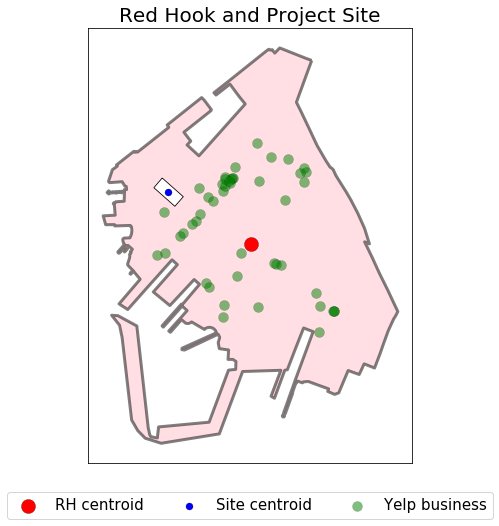

In [13]:
# Red Hook centroid in red with buffer and site in blue with buffer
f, ax = plt.subplots(figsize=(8,8))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Red Hook combined census tracts with centroid
rh_comb_tract.plot(alpha=.5,linewidth=3,ax=ax,color='pink',edgecolor='black')
rh_comb_center.plot(alpha=1, linewidth=0.2,ax=ax,color='r',edgecolor='black',markersize=200,label='RH centroid')

# Site block with centroid
site_poly.plot(alpha=1,linewidth=0.8,ax=ax,color='w',edgecolor='black')
site_centroid.plot(alpha=1, linewidth=0.2,ax=ax,color='b',edgecolor='black',markersize=50,label='Site centroid')

# Yelp businesses
biz_df_rh.plot(alpha=.5, linewidth=0.2,ax=ax,color='g',edgecolor='black',markersize=100,label='Yelp business')

# Show plot
plt.title("Red Hook and Project Site", fontsize=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),ncol=5,fontsize=15)
plt.show()

## Getting Yelp reviews from nearby establishments

Here's more info on the API query for Yelp reviews:

https://www.yelp.com/developers/documentation/v3/business_reviews

Note that this API call is limited to only 3 reviews per establishment.

In [14]:
# Use the businesses that were returned from the previous query
biz_ids = list(biz_df.id)

In [15]:
# API call for reviews
reviews = []
for biz_id in biz_ids:
    review = get_review(API_KEY, biz_id)
    reviews.append(review)

In [16]:
# Make a df from those reviews
reviews_df = pd.DataFrame(reviews)
reviews_df.head()

,possible_languages,reviews,total
0,"[fr, en, it, ja]","[{'id': '3Kk3SEePI12jF99pmPpbww', 'url': 'http...",1212
1,"[en, it]","[{'id': 'WLhCbdA75IFVMm9Isk8LLg', 'url': 'http...",946
2,[en],"[{'id': '63UNNOriaxChZdtugnBhuw', 'url': 'http...",496
3,"[en, es]","[{'id': 'WRl3GkRzzoQsvapYIm4l3Q', 'url': 'http...",314
4,[en],"[{'id': 'sgUrk59Q00gNtMY2njLZhQ', 'url': 'http...",400


In [17]:
# Split the reviews into separate columns
reviews_df = pd.concat([reviews_df, reviews_df['reviews'].apply(pd.Series)], axis = 1).drop('reviews', \
                                                                                               axis = 1)
# And break out each part of each review into separate columns
for i in range(3):
    df_sep = reviews_df[i].apply(pd.Series)
    df_sep.rename(columns={'id':'id_{}'.format(i),'url':'url_{}'.format(i),'text':'text_{}'.format(i),\
                           'rating':'rating_{}'.format(i),'time_created':'time_created_{}'.format(i),\
                           'user':'user_{}'.format(i)}, inplace=True)
    reviews_df = pd.concat([reviews_df, df_sep], axis = 1).drop([i], axis = 1)

reviews_df.head()

/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/api.py:107: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  result = result.union(other)
/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/api.py:69: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  index = _union_indexes(indexes, sort=sort)
/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/api.py:107: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)


,possible_languages,total,id_0,url_0,text_0,rating_0,time_created_0,user_0,id_1,url_1,...,time_created_1,user_1,0,id_2,url_2,text_2,rating_2,time_created_2,user_2,0
0,"[fr, en, it, ja]",1212,3Kk3SEePI12jF99pmPpbww,https://www.yelp.com/biz/hometown-bar-b-que-br...,Got there on Sunday 7pm and waited around 1 ho...,5,2019-05-19 20:52:52,"{'id': '0OXLVvlEwIF_Gwevw_aI-w', 'profile_url'...",ew1mP1KmLE22z5HEMvGo8A,https://www.yelp.com/biz/hometown-bar-b-que-br...,...,2019-05-31 13:37:35,"{'id': 'AbQEO3IbKCVBKIlZR7SFOA', 'profile_url'...",NaN,K-ek4Rl5Mab2vByBbRwSJA,https://www.yelp.com/biz/hometown-bar-b-que-br...,My friend and I were feeling a hankering for s...,4.0,2019-05-24 18:25:27,"{'id': '0Ogo6CJp-rwk0s1afRSQmw', 'profile_url'...",NaN
1,"[en, it]",946,WLhCbdA75IFVMm9Isk8LLg,https://www.yelp.com/biz/red-hook-lobster-poun...,"I had a major lobster craving, hauled myself t...",5,2019-01-04 06:29:40,"{'id': '-mHn6PHX8V8QepZMaifSNQ', 'profile_url'...",QM0X6qjMcWW0UVW6Pyjd3Q,https://www.yelp.com/biz/red-hook-lobster-poun...,...,2019-06-04 10:55:23,"{'id': '-Ct5EXCvnDOzJKXzgOj8pQ', 'profile_url'...",NaN,2Wp9urcIW5IQL16S-SoR3Q,https://www.yelp.com/biz/red-hook-lobster-poun...,Absolutely Awful. Fried lobster roll had an As...,1.0,2019-04-28 13:43:12,"{'id': 'gMP9SQXggXuVJ2gvvEgGhQ', 'profile_url'...",NaN
2,[en],496,63UNNOriaxChZdtugnBhuw,https://www.yelp.com/biz/baked-brooklyn?adjust...,"I'm drooling writing this review. Great, now I...",5,2019-03-27 16:55:56,"{'id': 'bt51F2SgYVcPWvNuDwZwXQ', 'profile_url'...",cAN-S1EKgFuUDQ3x4_CpxQ,https://www.yelp.com/biz/baked-brooklyn?adjust...,...,2019-05-20 08:21:16,"{'id': 'IiyfDn8KDVWJVzr36XixMQ', 'profile_url'...",NaN,eo5zpZ5ene8-humhz6vkBw,https://www.yelp.com/biz/baked-brooklyn?adjust...,Love Baked!! It is a block from my daughter's ...,4.0,2019-04-20 11:40:09,"{'id': 'W8AK0XlpePkv2epHeqLWxg', 'profile_url'...",NaN
3,"[en, es]",314,WRl3GkRzzoQsvapYIm4l3Q,https://www.yelp.com/biz/defontes-brooklyn?adj...,Roast beef mozz and eggplant sandwich = heaven...,5,2019-04-05 19:37:05,"{'id': 'IuP4sr2yvJjaAuWYPFjiHg', 'profile_url'...",8phz-YlOtGkMzObgWxB7fQ,https://www.yelp.com/biz/defontes-brooklyn?adj...,...,2018-12-31 15:00:01,"{'id': '0Sw9sDJy9beVwPX6EfOKeg', 'profile_url'...",NaN,JGsuQbunX7yvhd-XSKQNPA,https://www.yelp.com/biz/defontes-brooklyn?adj...,We are from PA but every time we head to Brook...,5.0,2019-06-01 08:45:31,"{'id': 'MWyBec4LwBJNFigts9VArQ', 'profile_url'...",NaN
4,[en],400,sgUrk59Q00gNtMY2njLZhQ,https://www.yelp.com/biz/the-good-fork-brookly...,"Whenever we have friends it town, we love to t...",5,2019-03-02 08:39:03,"{'id': 'zStyOPR14YzDFNmXRQMBrQ', 'profile_url'...",K5cW0gHZ_BdAoO2QCY6pfg,https://www.yelp.com/biz/the-good-fork-brookly...,...,2019-05-30 05:39:49,"{'id': 'JZ1QkXIszrMBtpDMZrWZog', 'profile_url'...",NaN,FuZ4iXW-hq5oK-U6rNm0SQ,https://www.yelp.com/biz/the-good-fork-brookly...,"I went in August and it was great, but most re...",2.0,2019-04-04 10:10:39,"{'id': 'SwvoOnfwvtxVDZOX_JcRGA', 'profile_url'...",NaN


In [18]:
# Merge back with the establishment names
reviews_merge = pd.concat([reviews_df,biz_df.name],axis=1)
reviews_merge.head()

,possible_languages,total,id_0,url_0,text_0,rating_0,time_created_0,user_0,id_1,url_1,...,user_1,0,id_2,url_2,text_2,rating_2,time_created_2,user_2,0,name
0,"[fr, en, it, ja]",1212,3Kk3SEePI12jF99pmPpbww,https://www.yelp.com/biz/hometown-bar-b-que-br...,Got there on Sunday 7pm and waited around 1 ho...,5,2019-05-19 20:52:52,"{'id': '0OXLVvlEwIF_Gwevw_aI-w', 'profile_url'...",ew1mP1KmLE22z5HEMvGo8A,https://www.yelp.com/biz/hometown-bar-b-que-br...,...,"{'id': 'AbQEO3IbKCVBKIlZR7SFOA', 'profile_url'...",NaN,K-ek4Rl5Mab2vByBbRwSJA,https://www.yelp.com/biz/hometown-bar-b-que-br...,My friend and I were feeling a hankering for s...,4.0,2019-05-24 18:25:27,"{'id': '0Ogo6CJp-rwk0s1afRSQmw', 'profile_url'...",NaN,Hometown Bar-B-Que
1,"[en, it]",946,WLhCbdA75IFVMm9Isk8LLg,https://www.yelp.com/biz/red-hook-lobster-poun...,"I had a major lobster craving, hauled myself t...",5,2019-01-04 06:29:40,"{'id': '-mHn6PHX8V8QepZMaifSNQ', 'profile_url'...",QM0X6qjMcWW0UVW6Pyjd3Q,https://www.yelp.com/biz/red-hook-lobster-poun...,...,"{'id': '-Ct5EXCvnDOzJKXzgOj8pQ', 'profile_url'...",NaN,2Wp9urcIW5IQL16S-SoR3Q,https://www.yelp.com/biz/red-hook-lobster-poun...,Absolutely Awful. Fried lobster roll had an As...,1.0,2019-04-28 13:43:12,"{'id': 'gMP9SQXggXuVJ2gvvEgGhQ', 'profile_url'...",NaN,Red Hook Lobster Pound
2,[en],496,63UNNOriaxChZdtugnBhuw,https://www.yelp.com/biz/baked-brooklyn?adjust...,"I'm drooling writing this review. Great, now I...",5,2019-03-27 16:55:56,"{'id': 'bt51F2SgYVcPWvNuDwZwXQ', 'profile_url'...",cAN-S1EKgFuUDQ3x4_CpxQ,https://www.yelp.com/biz/baked-brooklyn?adjust...,...,"{'id': 'IiyfDn8KDVWJVzr36XixMQ', 'profile_url'...",NaN,eo5zpZ5ene8-humhz6vkBw,https://www.yelp.com/biz/baked-brooklyn?adjust...,Love Baked!! It is a block from my daughter's ...,4.0,2019-04-20 11:40:09,"{'id': 'W8AK0XlpePkv2epHeqLWxg', 'profile_url'...",NaN,Baked
3,"[en, es]",314,WRl3GkRzzoQsvapYIm4l3Q,https://www.yelp.com/biz/defontes-brooklyn?adj...,Roast beef mozz and eggplant sandwich = heaven...,5,2019-04-05 19:37:05,"{'id': 'IuP4sr2yvJjaAuWYPFjiHg', 'profile_url'...",8phz-YlOtGkMzObgWxB7fQ,https://www.yelp.com/biz/defontes-brooklyn?adj...,...,"{'id': '0Sw9sDJy9beVwPX6EfOKeg', 'profile_url'...",NaN,JGsuQbunX7yvhd-XSKQNPA,https://www.yelp.com/biz/defontes-brooklyn?adj...,We are from PA but every time we head to Brook...,5.0,2019-06-01 08:45:31,"{'id': 'MWyBec4LwBJNFigts9VArQ', 'profile_url'...",NaN,Defontes
4,[en],400,sgUrk59Q00gNtMY2njLZhQ,https://www.yelp.com/biz/the-good-fork-brookly...,"Whenever we have friends it town, we love to t...",5,2019-03-02 08:39:03,"{'id': 'zStyOPR14YzDFNmXRQMBrQ', 'profile_url'...",K5cW0gHZ_BdAoO2QCY6pfg,https://www.yelp.com/biz/the-good-fork-brookly...,...,"{'id': 'JZ1QkXIszrMBtpDMZrWZog', 'profile_url'...",NaN,FuZ4iXW-hq5oK-U6rNm0SQ,https://www.yelp.com/biz/the-good-fork-brookly...,"I went in August and it was great, but most re...",2.0,2019-04-04 10:10:39,"{'id': 'SwvoOnfwvtxVDZOX_JcRGA', 'profile_url'...",NaN,The Good Fork


## Word search

Searching for text indicating gentrification. Possible words to be included were pulled from:

https://wordassociations.net/en/words-associated-with/Gentrification?start=0

In [19]:
# List of words associated with gentrification for searching
gent_words = ['gentrification', 'gentrify', 'gentrified', 'change', 'redevelopment', 'redeveloped', 'displaced',\
            'displacement', 'renewal', 'segregation', 'enclave', 'regeneration', 'decay', 'decline', 'trend', \
              'trendy', 'starbucks', 'marxist', 'affluent', 'demographic', 'displace', 'rehabilitate']

In [20]:
# List of words associated with neighborhoods in general for searching
neighb_words = ['neighborhood', 'neighb']

In [21]:
# Searching the text for the first review of each business
rev0 = reviews_df.iloc[:,4]

In [22]:
# Search for gentrification terms
rev0[rev0.str.contains('|'.join(gent_words))]

50    This place has survived the gentrification of ...
Name: text_0, dtype: object

In [23]:
# Just a search for general neighborhood words
rev0[rev0.str.contains('|'.join(neighb_words))]

8     Oh! My! God! Chef David! \nOne of the Best exp...
40    Coffey Park is your friendly neighborhood park...
44    I was getting my car fixed nearby and was wand...
Name: text_0, dtype: object

# Next steps/to dos:

* How to process reviews/text?